In [2]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np
from tqdm import tqdm

## Feature Matching
This script identifies keypoints and generates descriptors in two images using detectors like SIFT or other options available in OpenCV. The subsequent step involves matching each keypoint in the first image with corresponding points in the second image using a brute force matcher. Specifically, for each keypoint in the first image, the script calculates the distances between the descriptors of that point and all the descriptors in the second image. The keypoint in the second image with the minimum distance is considered a match. The matches are then sorted based on distance, and the script plots the top few matches for visualization.

[Additional reading](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

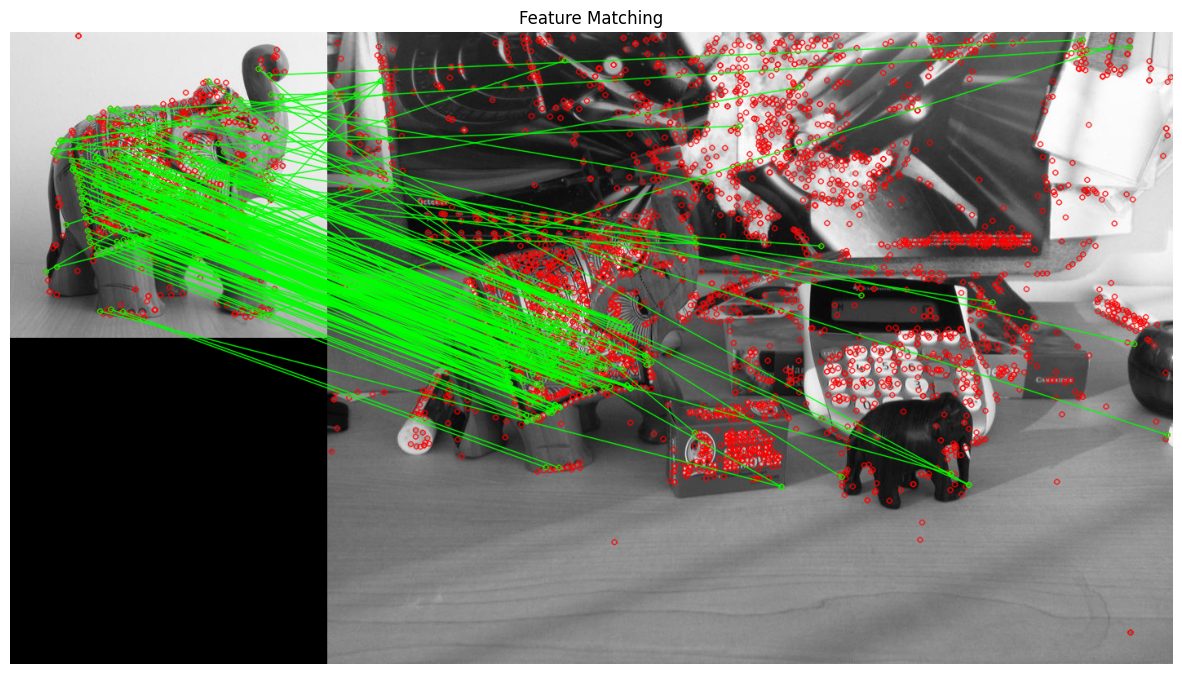

(None,)

In [3]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort them in ascending order of distance 
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:200], 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))

# Plot the matches using Matplotlib
plt.figure(figsize=(15,15))
plt.imshow(img_matches)
plt.title('Feature Matching'),plt.axis('off')
plt.show(), 

## Feature matching with ratio test
This script performs the same keypoint detection, descriptor generation, and matching process as the previous one. However, it introduces a ratio test during the matching phase. Instead of selecting the point with the minimum distance, it considers the ratio of the distances between the best and second-best matches. If this ratio is below a certain threshold, the match is considered valid. The script then proceeds to sort and visualize the matches based on this ratio test.

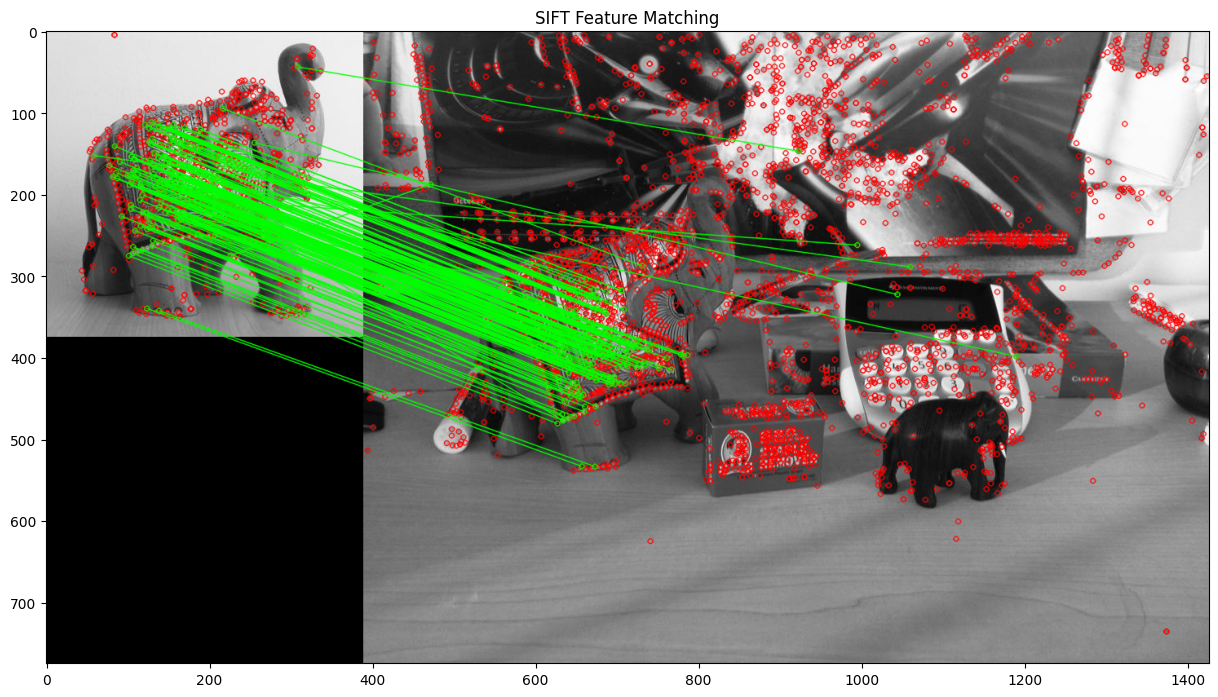

In [4]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good, 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))

# Plot the matches using Matplotlib
plt.figure(figsize=(15,15))
plt.imshow(img_matches)
plt.title('SIFT Feature Matching')
plt.show()

## Affine Transformation

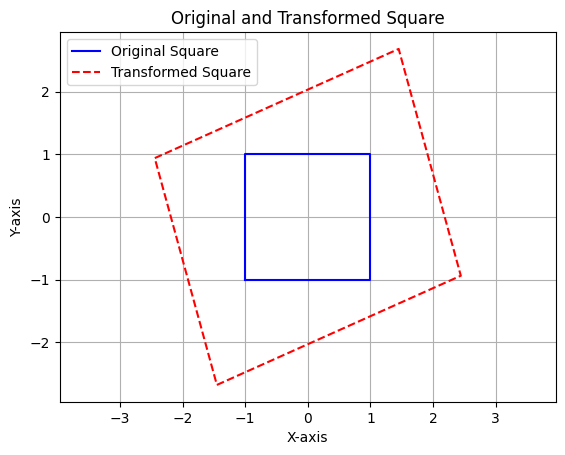

In [25]:
# Tranforming points
# Define the original square points (counter-clockwise order)
original_pts = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1], [-1, -1]]).T
original_pts = np.row_stack((original_pts, np.ones(original_pts.shape[1])))

# Plot the original square
plt.plot(original_pts[0,:], original_pts[1,:], label='Original Square', color='blue')

# transformation Matrix
scale_factor = 2
rotation_angle = 20  # in degrees
shear_factor = .1

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])

# Combine the matrices to get the homography matrix
#affine_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))
affine_matrix = shear_matrix @ rotation_matrix @ scale_matrix

# Apply the transformation to each point
transformed_pts = affine_matrix @ original_pts

# Plot the transformed square
plt.plot(transformed_pts[0,:], transformed_pts[1,:], label='Transformed Square', linestyle='dashed', color='red')

# Set plot properties
plt.title('Original and Transformed Square')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


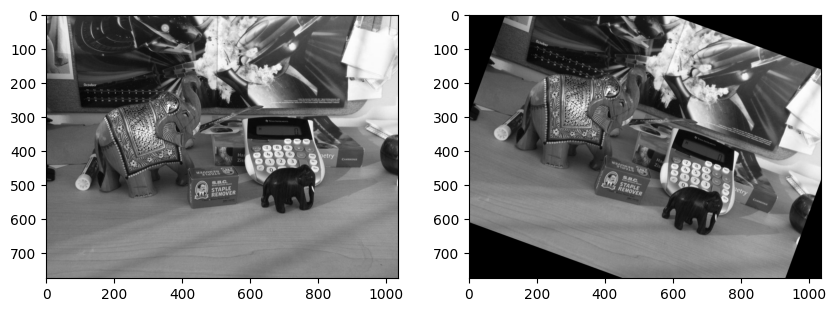

In [26]:
# Load the image
image = cv2.imread('data/images/sceneImage.png')

# Define scale, rotation, and shear factors
scale_factor = 1
rotation_angle = 20  # in degrees
shear_factor = 0

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])
# Combine the matrices to get the homography matrix
affine_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))

if 0:
    # top-left pixel is the origin
    # Apply the transformation using warpPerspective
    output_image = cv2.warpPerspective(image, affine_matrix, (image.shape[1], image.shape[0]))

else:
    # Make center of image as the origin
    T_matrix = np.array([[1, 0, image.shape[1]/2],
                     [0, 1, image.shape[0]/2],
                     [0, 0, 1]])
    affine_matrix = np.dot(np.dot(T_matrix, affine_matrix), np.linalg.inv(T_matrix))
    output_image = cv2.warpPerspective(image, affine_matrix, (image.shape[1], image.shape[0]))

# Display the original and transformed images
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow( image)
plt.subplot(122)
plt.imshow( output_image)

### Homography

Homography is a type of transformation that links two different images, mapping points from one image to another. Think of it as a way to transform one image plane (like a photo) into another, making the two images align with each other, even if they were taken from different angles.

### Affine Transformations
Affine transformations are simpler than homography. They involve:
- **Translation:** Moving an image from one place to another.
- **Scaling:** Making the image bigger or smaller.
- **Rotation:** Turning the image around a point.
- **Shearing:** Skewing the image like a parallelogram.

#### Properties of Affine Transformations:
- **Lines stay as lines**: Straight edges in the image will remain straight.
- **Parallel lines stay parallel**: If two lines are parallel in the original image, they'll still be parallel after transformation.
- **Ratios are preserved**: The relative size of objects in the image remains the same.
- **Closed under composition**: Applying multiple affine transformations one after another still results in an affine transformation.

### Projective Transformations
Projective transformations are a more complex version of affine transformations. They combine affine transformations with additional warping (like when an object looks distorted because it's being viewed from an angle).

#### Properties of Projective Transformations:
- **Lines stay as lines**: Like affine, straight edges remain straight.
- **Parallel lines don't always stay parallel**: Unlike affine, lines that are parallel may no longer be parallel after the transformation (imagine how railroad tracks look like they converge in the distance).
- **Ratios are not preserved**: The relative size of objects may change.
- **Closed under composition**: Like affine transformations, applying multiple projective transformations results in a new projective transformation.
- **Projective matrix has 8 degrees of freedom (DOF)**: The matrix that defines this transformation is more flexible and can model more complex changes in perspective.
- In summary, while affine transformations handle basic transformations (like resizing, rotating, and shifting), projective transformations can deal with more complex changes in perspective, like when an object appears stretched or compressed based on the viewer's angle.

Projective Transformations are also called Homography.
A projective transformation is represented by a **3x3 matrix**, which looks like this:
$$
\begin{pmatrix}
a & b & c \\
d & e & f \\
g & h & 1
\end{pmatrix}
$$

- This matrix has 9 elements, The matrix has 8 independent parameters.
- These 8 parameters give the projective transformation **8 degrees of freedom** (DOF). They allow the transformation to handle **translation, rotation, scaling, shearing**, and **perspective distortion** (how objects appear smaller in the distance).

### What DOF Represents:
- **In practice**, the 8 DOF in projective transformations mean that given 4 matched points in the two images you can find the Homography matrix that relates the two images.
(8 DOF)
sition,


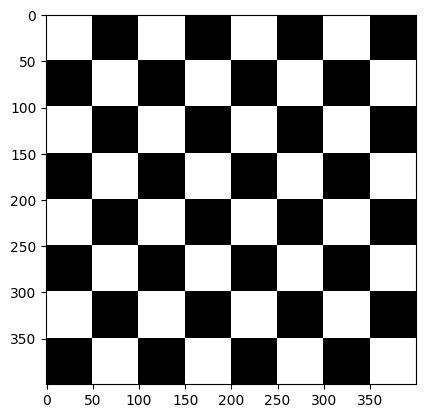

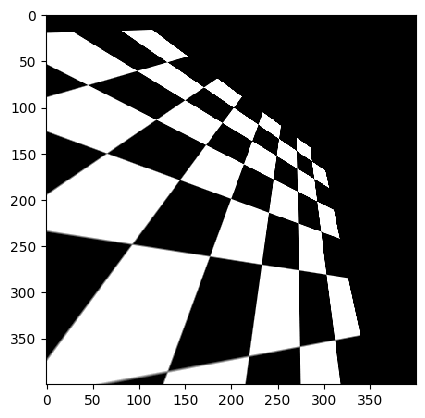

In [37]:
def create_checkerboard(rows, cols, square_size):
    checkerboard = np.zeros((rows*square_size, cols*square_size), dtype=np.uint8)

    for i in range(rows*square_size):
        for j in range(cols*square_size):
            if (i // square_size) % 2 == (j // square_size) % 2:
                checkerboard[i, j] = 255  # Set to white (255 in uint8)

    return checkerboard

rows, cols = 8, 8  # Number of rows and columns
square_size = 50   # Size of each square in pixels

checkerboard = create_checkerboard(rows, cols, square_size)

# Create a homography matrix
scale_factor = 1
rotation_angle = 20  # in degrees
# Create transformation matrices

scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])
rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

# Combine the matrices to get the homography matrix
H = np.dot(rotation_matrix, scale_matrix)
H[2,:2] = np.array([0.003,-0.005])
T_matrix = np.array([[1, 0, checkerboard.shape[1]/2],
                     [0, 1, checkerboard.shape[0]/2],
                     [0, 0, 1]])

H = np.dot(np.dot(T_matrix, H), np.linalg.inv(T_matrix))

# Apply the transformation using warpPerspective
output_image = cv2.warpPerspective(checkerboard, H, (checkerboard.shape[1], checkerboard.shape[0]))

# Display the checkerboard using matplotlib
plt.imshow(checkerboard, cmap='gray', interpolation='nearest')
#plt.plot(pts1[:,0], pts1[:,1],'r+')
plt.show()
plt.imsave('checkerboard1.png',checkerboard)
plt.imshow(output_image, cmap='gray', interpolation='nearest')
#plt.plot(pts2[:,0], pts2[:,1],'r+')
plt.imsave('checkerboard2.png', output_image)

## Feature Matching + Ransac-based Homography
This script employs feature detection and descriptor generation in two images through detectors such as SIFT or other options provided by OpenCV. Following this, it matches each keypoint in the first image to corresponding points in the second image using a brute-force matcher. A ratio test is then applied to refine and sort the keypoints. Lastly, RANSAC is employed to estimate the homography matrix and eliminate unreliable matches

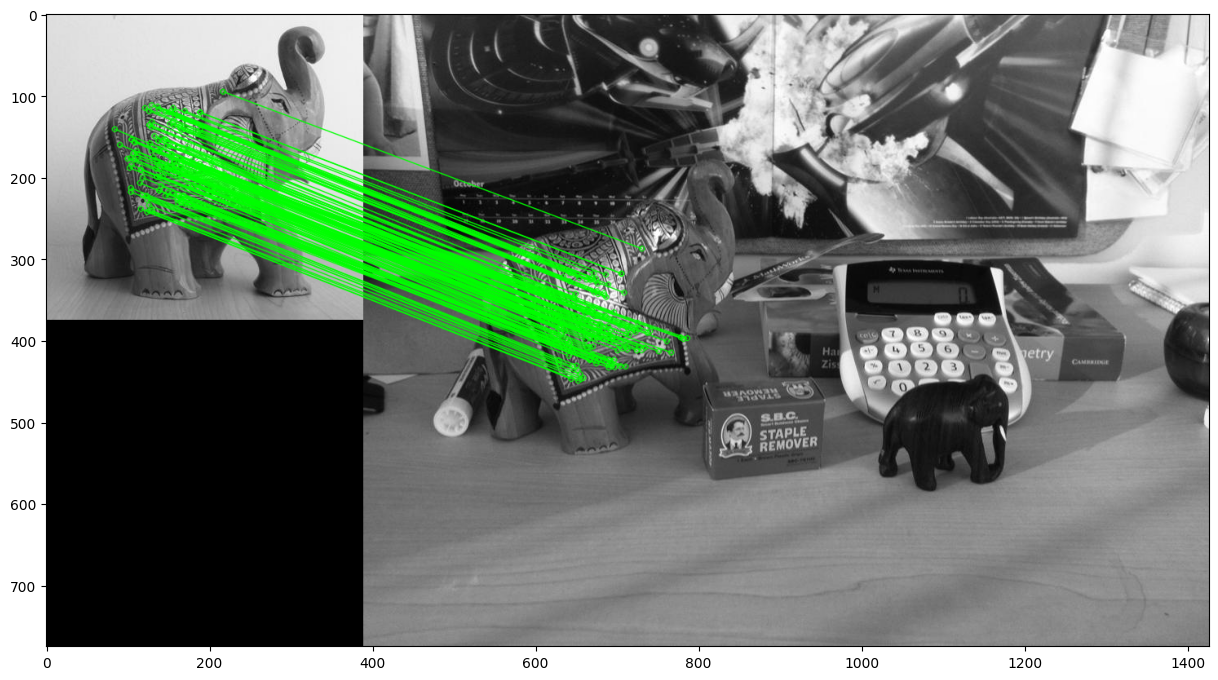

(<matplotlib.image.AxesImage at 0x15797aec0>, None)

In [116]:
# Load the images
image1 = cv2.imread('data/images/elephantImage.png')
image2 = cv2.imread('data/images/sceneImage.png')

# Initialize the SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors 
kp1, des1 = feat.detectAndCompute(image1, None)
kp2, des2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

# Draw the matching 
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(output_image, 'gray'),plt.show()

## Object recognition: 
We can now locate the object in the image

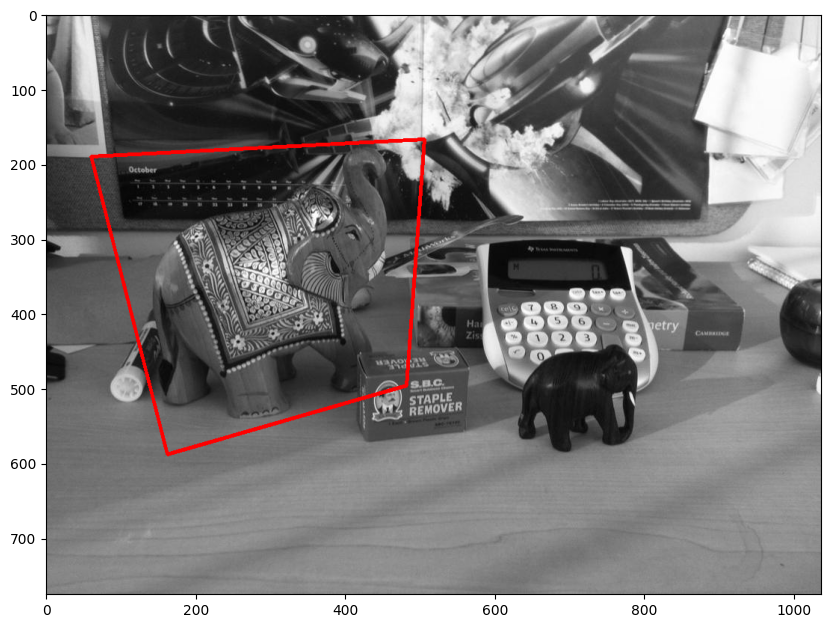

(<matplotlib.image.AxesImage at 0x15799f460>, None)

In [117]:
h,w = image1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,H)
output_image = cv2.polylines(image2,[np.int32(dst)],True,255,3)

plt.figure(figsize=(10,10))
plt.imshow(output_image, 'gray'),plt.show()

## Image Stitching
We will follow a nearly identical procedure as in the previous scenario to merge two images, creating a panoramic view.

In [175]:
def stitch_img(image1, image2, H):
    # Find the corners of the transformed image
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)
    corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)
    
    transformed_corners = cv2.perspectiveTransform(corners1, H) # only corners 1 undergo transformation
    transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)
    
    # Find the minimum and maximum coordinates to get the dimensions of the panoramic image
    min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())
    max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())
    
    # Adjust the homography matrix to account for the shift
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    adjusted_homography_matrix = np.dot(translation_matrix, H)
    
    # Apply the adjusted homography to warp the image
    stitched_image = cv2.warpPerspective(image1, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
    stitched_image[-min_y:image2.shape[0] - min_y, -min_x:image2.shape[1] - min_x,:] = image2
    
    return stitched_image

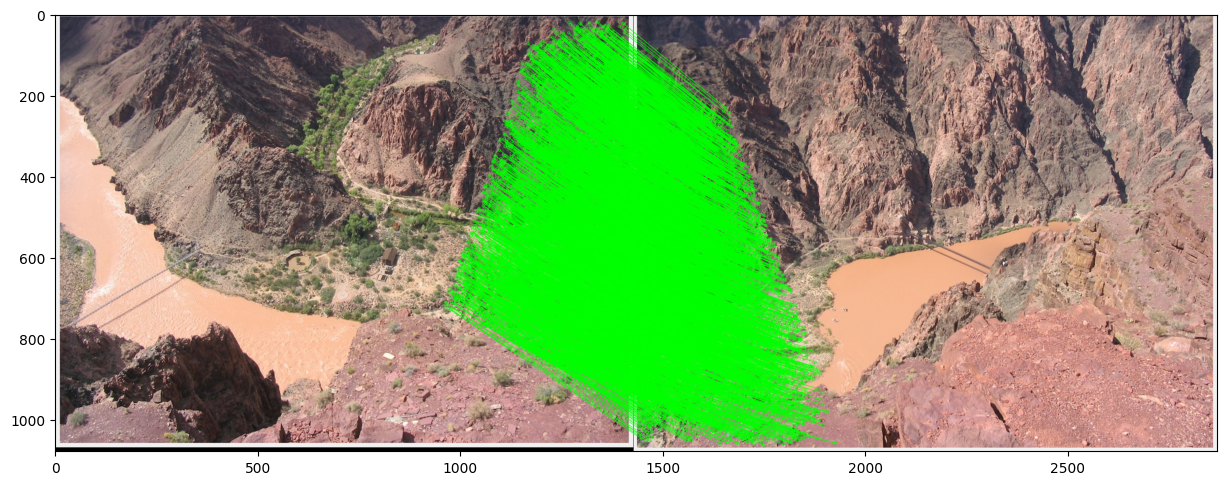

(<matplotlib.image.AxesImage at 0x155be2380>, None)

In [173]:
# Load the images
image1 = cv2.imread('data/images/scene1.png')
image2 = cv2.imread('data/images/scene2.png')

# Initialize the SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = feat.detectAndCompute(image1, None)
kp2, des2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

# Draw the matching 
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)), plt.show()

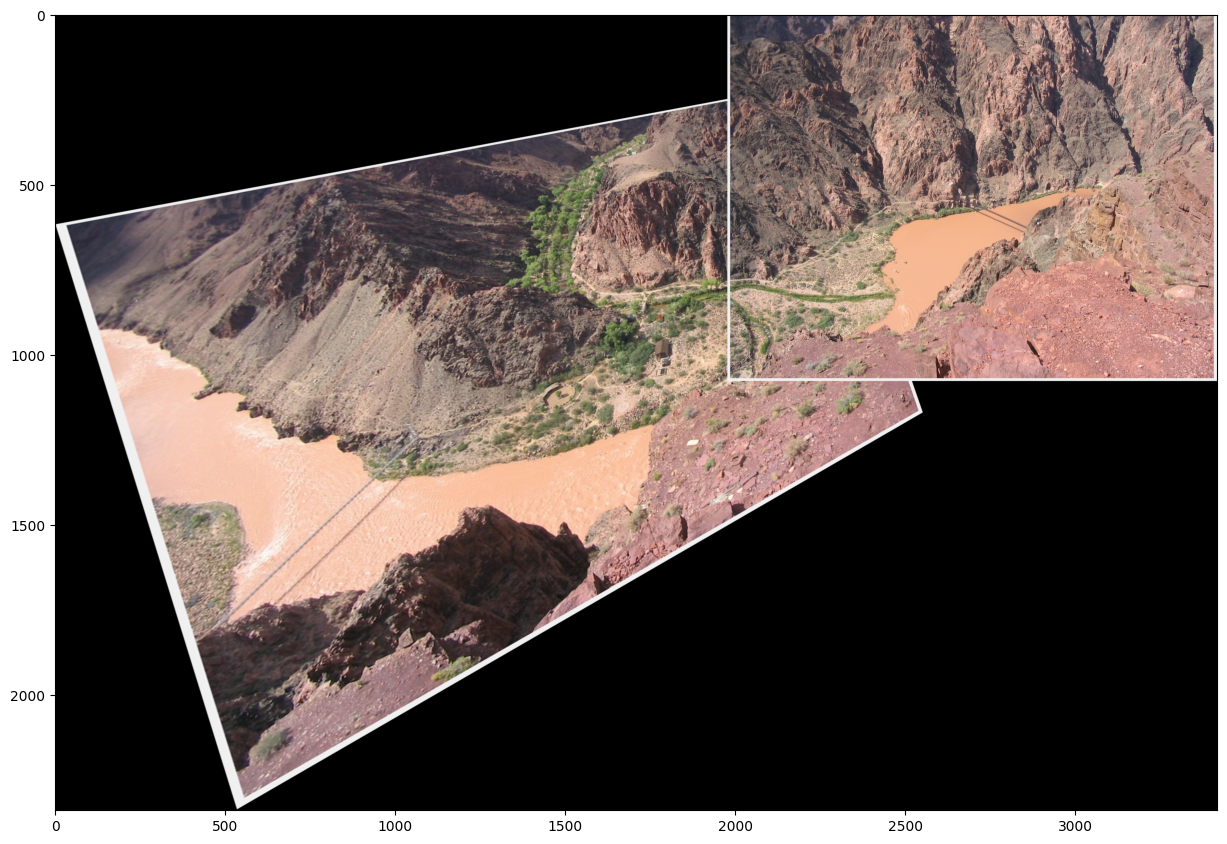

(<matplotlib.image.AxesImage at 0x168a62d40>, None)

In [176]:
stitch_image = stitch_img(image1, image2, H)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(stitch_image, cv2.COLOR_BGR2RGB)), plt.show()

## Image Rectification

Rectifying the image to ensure it is aligned directly facing the camera

<img src="homograpy.jpg" alt="drawing" width="500"/>

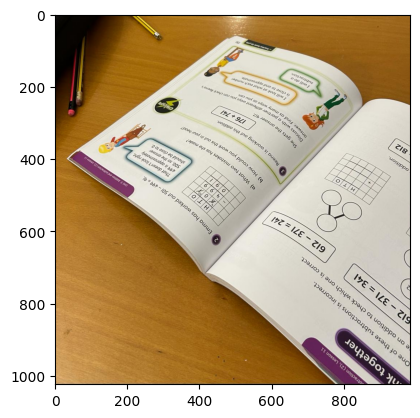

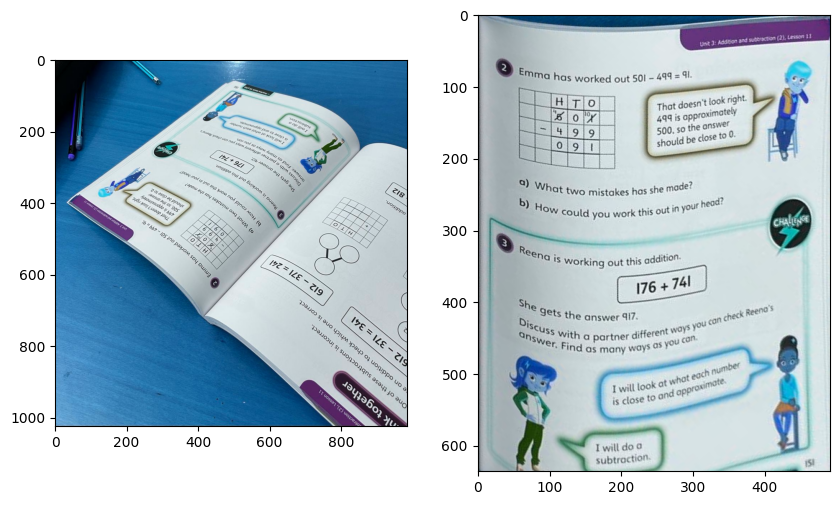

In [184]:
# Load the image
image = cv2.imread('data/images/book.jpeg')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# pts = plt.ginput(4) 
pts = [(414, 718), #top-left
       (38, 402),  #top-right
       (851, 255), #bottom-left
       (493, 64)]  #bottom-right

input_pts = np.array(pts, dtype=np.float32)

width = (np.linalg.norm(input_pts[0]-input_pts[1]), np.linalg.norm(input_pts[2]-input_pts[3]))
height = (np.linalg.norm(input_pts[0]-input_pts[2]), np.linalg.norm(input_pts[1]-input_pts[3]))
width = int(np.max(width))
height = int(np.max(height))

output_pts = np.array([(0, 0), 
          (width-1, 0),
          (0, height-1),
          (width-1,height-1)], np.float32)

# compute the homography matrix
H = cv2.getPerspectiveTransform(input_pts, output_pts)

# Apply Transformation
output_image = cv2.warpPerspective(image, H, (width, height), flags=cv2.INTER_LINEAR)

# Display the original and transformed images
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow( image)
plt.subplot(122)
plt.imshow( output_image)